In [1]:
from pathlib import Path
from analysis import files, analysis
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

root_data_path = Path("/Users/spencer/motor-control/data")
metadata_path = root_data_path / "metadata" / "emg_olympics"

### how are the offsets and variance calculated?

offsets -- extract quiescent periods before movement cue is given, filter these and take the mean. this is then subtracted from the "live" signal as a mean shift.

variance -- this is computed per channel from the calibration bars dataset, divided per channel as a whitening

In [2]:
olympics_subjects = files.get_subjects("emg_olympics")
olympics_subjects.sort()
repeat_subjects = files.get_subjects("emg_repeats")
repeat_subjects.sort()

In [43]:
norm0 = []
norm1 = []
cosines = []
decoders = []
for subject in olympics_subjects:
    decoder = files.load_array_from_disk(metadata_path / subject / "decoder.bin").reshape(-1,64)
    print(np.min(decoder))
    decoders.append(decoder)
    # absolute value cosine
    cosines.append((np.dot(*decoder[-2:]) / (np.linalg.norm(force_axes[0])*np.linalg.norm(force_axes[1]))))

-0.48202842
-0.47527778
-0.7313373
-0.5643043
-0.7125061
-0.5671662
-0.49227253
-0.48446435
-0.6021958
-0.7385004
-0.41137046
-0.5056253
-0.7457369
-0.53332245
-0.47518188
-0.47699404
-0.47662038
-0.4890108
-0.64502525
-0.50198203
-0.41753316
-0.63742995
-0.60339683
-0.5323923
-0.46414736
-0.63234985
-0.51194113
-0.5649269
-0.686727
-0.39025638
-0.47062925
-0.4454804
-0.5198217
-0.6481762
-0.77708334
-0.6949162
-0.6436865
-0.4542983
-0.5901516
-0.49325532
-0.69909745
-0.6227202
-0.54280424
-0.4738068
-0.5670776
-0.42817435


In [35]:
def calculate_hit_fractions_per_session(hits):
    num_targets = 12
    return [h * (100 / 12) for h in hits]
    
def calculate_total_fraction(hits):
    num_targets = 12
    return 100 * sum(hits) / (num_sessions * 12)

def log(x, a, b):
    return b * np.log(x) + a

In [36]:
noholds_subjects = []
fractions_subjects = []
total_fractions = []
for subject in olympics_subjects:
    hits, misses, noholds, num_sessions, reach_times = analysis.get_outcomes("emg_olympics", subject)
    noholds_subjects.append(noholds)
    fractions_subjects.append(calculate_hit_fractions_per_session(hits))
    total_fractions.append(calculate_total_fraction(hits))

In [37]:
learning_rates = []
baselines = []
x = np.linspace(0,num_sessions,50)
num_sessions = 45
for subject_fractions in fractions_subjects:
    popt, pcov = curve_fit(log, list(range(1, num_sessions+1)), subject_fractions[:num_sessions])
    learning_rates.append(popt[1])
    baselines.append(round(popt[0],1))

## plot decoder example

Text(0.5, 0, 'Radial Decoder Channel ($y$)')

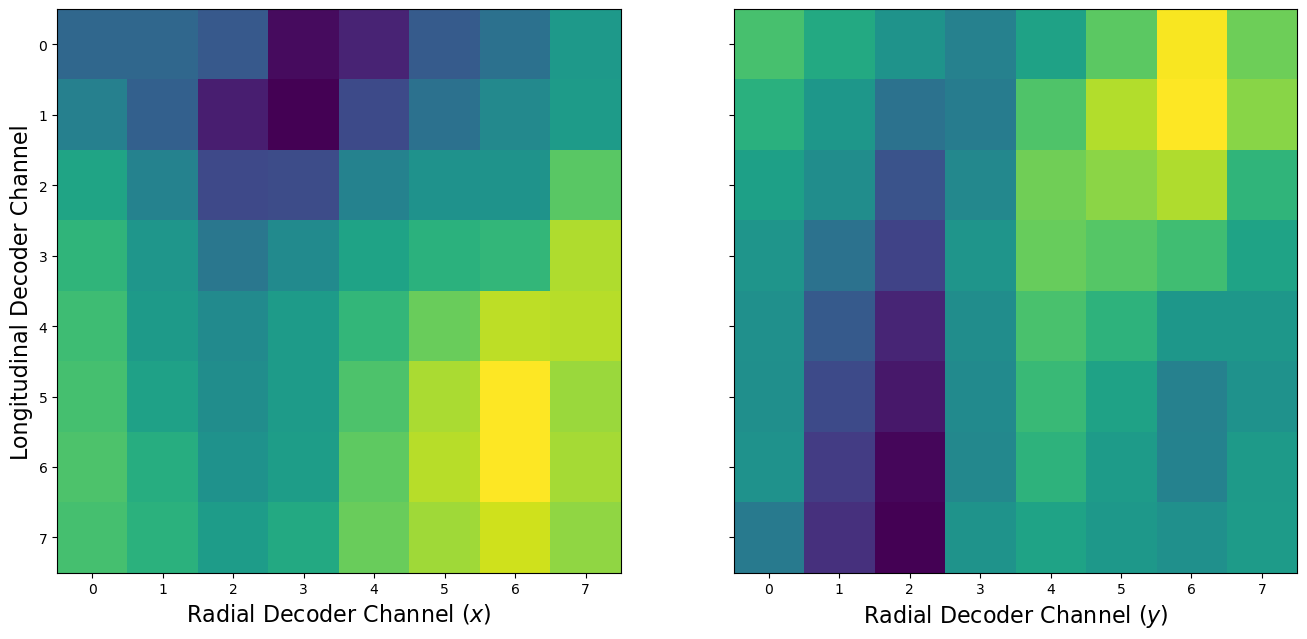

In [92]:
subject = 37
decoder_heatmap_fig, axes = plt.subplots(1,2,figsize=[16,8],sharex=True, sharey=True)
axes[0].imshow(decoders[subject][-2,:].reshape(8,8))
axes[0].set_xlabel("Radial Decoder Channel ($x$)", fontsize=16)
axes[0].set_ylabel("Longitudinal Decoder Channel", fontsize=16)
axes[1].imshow(decoders[subject][-1,:].reshape(8,8))
axes[1].set_xlabel("Radial Decoder Channel ($y$)", fontsize=16)

In [93]:
decoder_heatmap_fig.savefig("/Users/spencer/motor-control/thesis/images/data_analysis2023/decoder_heatmap.pdf", dpi=300, format="pdf")

## plot outcomes vs. decoder correlation

0.05304496691303853


Text(0.5, 30, '$R^2$ = 0.053')

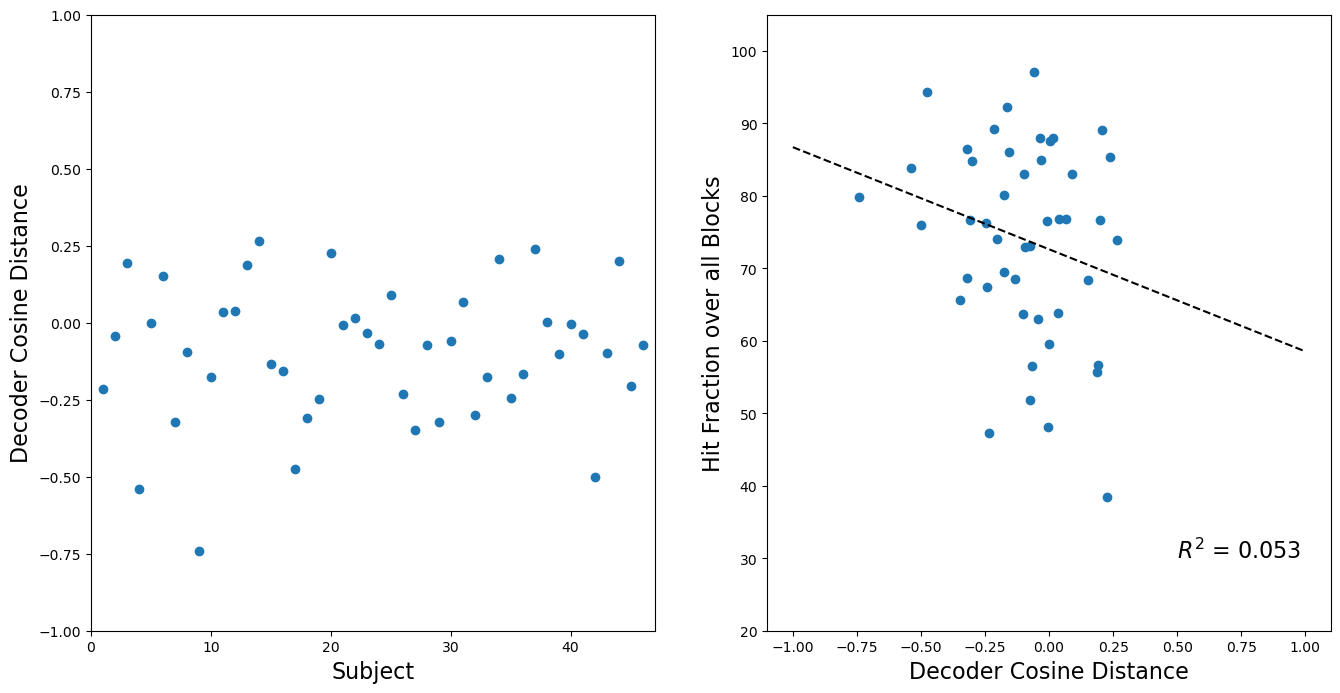

In [94]:
decoder_fig, (cos_ax, ax) = plt.subplots(1,2,figsize=(16,8))

# [-1,1] 1 is parallel, -1 is antiparallel, 0 is orthogonal
cos_ax.plot(range(1,len(cosines)+1), cosines,"o")
cos_ax.set_ylim([-1,1])
cos_ax.set_xlim([0,len(cosines)+1])
cos_ax.set_ylabel("Decoder Cosine Distance", fontsize=16)
cos_ax.set_xlabel("Subject", fontsize=16)

ax.plot(cosines, total_fractions ,"o")
from scipy.stats import linregress
result = linregress(cosines, total_fractions)
x = np.linspace(-1,1,100)
ax.plot(x, result.intercept + result.slope*x,"k--")
print(result.rvalue**2)
ax.set_ylim([20,105])
ax.set_xlim([-1.1,1.1])
ax.set_ylabel("Hit Fraction over all Blocks", fontsize=16)
ax.set_xlabel("Decoder Cosine Distance", fontsize=16)
ax.annotate(f"$R^2$ = {np.round(result.rvalue**2, 3)}", (0.5,30), fontsize=16)

In [95]:
decoder_fig.savefig("/Users/spencer/motor-control/thesis/images/data_analysis2023/decoder_correlation.pdf", dpi=300, format="pdf")

## null space

In [96]:
import numpy as np
from scipy.linalg import null_space

In [104]:
D = decoders[0][-2:]
D.shape

(2, 64)

In [101]:
NS = null_space(D)

In [102]:
NS.shape

(64, 62)